In [37]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss, accuracy_score
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

def read_atp_data(years):
    """
    Reads ATP matches data from CSV files for the specified years.

    Args:
        years (list or range): A list or range of years to read data for.

    Returns:
        pandas.DataFrame: A combined DataFrame containing all the data from the specified years.
    """
    data = []
    for year in years:
        # Check for Excel file with .xls extension
        xls_file_path = f"{year}.xls"
        if os.path.exists(xls_file_path):
            df = pd.read_excel(xls_file_path)
            data.append(df)
            continue

        # Check for Excel file with .xlsx extension
        xlsx_file_path = f"{year}.xlsx"
        if os.path.exists(xlsx_file_path):
            df = pd.read_excel(xlsx_file_path)
            data.append(df)
            continue

        # If the file is not found
        print(f"File not found: {xls_file_path}, or {xlsx_file_path}")

    if data:
        combined_data = pd.concat(data, ignore_index=True)
        return combined_data
    else:
        return None

In [38]:
def compute_point_difference(df):
    df.rename(columns={
        'Winner': 'winner_name',
        'Loser': 'loser_name',
        'WRank': 'winner_rank',
        'LRank': 'loser_rank',
        'WPts': 'winner_rank_points',
        'LPts': 'loser_rank_points',
        'Date': 'tourney_date'
    }, inplace=True)
    df["loser_rank"] = df["loser_rank"].fillna(100000)
    df["winner_rank"] = df["winner_rank"].fillna(100000)

    df["higher_rank_points"] = np.where(df["winner_rank"] < df["loser_rank"], df["winner_rank_points"], df["loser_rank_points"])
    df["lower_rank_points"] = np.where(df["winner_rank"] < df["loser_rank"], df["loser_rank_points"], df["winner_rank_points"])
    
    df["point_difference"] = df["higher_rank_points"] - df["lower_rank_points"]
    df["higher_rank_won"] = df["winner_rank"] < df["loser_rank"]
    df.dropna(inplace=True, subset=["point_difference"])
    df = df[~df['Comment'].isin(['Retired', 'Walkover'])]
    return df

In [39]:
def accuracy(pred, actual):
    return np.mean(pred == actual)

def calibration(prob, actual):
    return np.mean(prob) / np.mean(actual)

def log_loss(prob, actual):
    return -np.mean(actual * np.log(prob) + (1 - actual) * np.log(1 - prob))

def validation_stats_calculate(df):
    acc = accuracy(df["pred"], df["actual"])
    calib = calibration(df["prob"], df["actual"])
    ll = log_loss(df["prob"], df["actual"])
    return {"accuracy": acc, "calibration": calib, "log_loss": ll}

def validation_stats(df, model_name=None):
    stats = validation_stats_calculate(df)
    print(f"{model_name}")
    print(f" - Accuracy: {stats['accuracy']:.4f}")
    print(f" - Calibration: {stats['calibration']:.4f}")
    print(f" - Log Loss: {stats['log_loss']:.4f}")
    print("--------------------------------------")
    return stats

def make_predictions(df):
    df["pred"] = df["prob"] > 0.5
    return df

In [40]:
def get_elo_prob(elo1, elo2):
    return 1 / (1 + 10 ** ((elo2 - elo1) / 400))

In [41]:
def update_elo(winner_elo, loser_elo, k_func, winner_matches, loser_matches):
    prob = get_elo_prob(winner_elo, loser_elo)
    k_winner = k_func(winner_matches)
    k_loser = k_func(loser_matches)
    winner_elo += k_winner * (1 - prob)
    loser_elo += k_loser * (0 - (1 - prob))
    return winner_elo, loser_elo

In [42]:
def implement_elo(df, k_func):
    elo_ratings = {}
    matches_played = {}
    df_elo = df.copy()

    for index, row in df.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_elo = elo_ratings.get(winner, 1500)
        loser_elo = elo_ratings.get(loser, 1500)
        winner_matches = matches_played.get(winner, 0)
        loser_matches = matches_played.get(loser, 0)

        winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_func, winner_matches, loser_matches)

        elo_ratings[winner] = winner_new_elo
        elo_ratings[loser] = loser_new_elo
        matches_played[winner] = winner_matches + 1
        matches_played[loser] = loser_matches + 1

        df_elo.at[index, "elo_prob"] = get_elo_prob(winner_new_elo, loser_new_elo)
        df_elo.at[index, "winner_before_game"] = winner_elo
        df_elo.at[index, "loser_before_game"] = loser_elo

    return df_elo, elo_ratings

In [43]:
def get_bcm_probabilities(df):
    def implied_prob(row, bookie):
        alpha_w = row[f"{bookie}W"]
        beta_l = row[f"{bookie}L"]
        return beta_l / (alpha_w + beta_l)
    
    bookmakers = ["B365", "PS"]
    implied_probs_winner = []
    implied_probs_loser = []
    
    for _, row in df.iterrows():
        probs_winner = [implied_prob(row, bookie) for bookie in bookmakers]
        probs_loser = [1 - prob for prob in probs_winner]
        implied_probs_winner.append(probs_winner)
        implied_probs_loser.append(probs_loser)
    
    df["implied_prob_winner"] = np.mean(implied_probs_winner, axis=1)
    df["implied_prob_loser"] = np.mean(implied_probs_loser, axis=1)

    df["implied_prob_winner_norm"] = df["implied_prob_winner"] / (df["implied_prob_winner"] + df["implied_prob_loser"])
    df["implied_prob_loser_norm"] = df["implied_prob_loser"] / (df["implied_prob_winner"] + df["implied_prob_loser"])

    df["bcm_prob"] = df["implied_prob_winner_norm"]
    return df

In [44]:
def execute_elo_model(df_train, df_test, k_func, model_name):
    df_elo_train, elo_ratings = implement_elo(df_train, k_func)
    prob_higher_rank = []

    for i, row in df_test.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_elo = elo_ratings.get(winner, 1500)
        loser_elo = elo_ratings.get(loser, 1500)
        winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
        loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
        prob = get_elo_prob(winner_elo, loser_elo)
        prob_higher_rank.append(prob if row["higher_rank_won"] else 1 - prob)
        winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_func, winner_matches, loser_matches)
        elo_ratings[winner] = winner_new_elo
        elo_ratings[loser] = loser_new_elo

    df_elo_test = df_test.copy()
    df_elo_test["prob"] = prob_higher_rank
    df_elo_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
    df_elo_test = make_predictions(df_elo_test)
    stats = validation_stats(df_elo_test, model_name=model_name)

    return stats

In [45]:
years = range(2013, 2023)  
df = read_atp_data(years)
df = compute_point_difference(df)
df["tourney_date"] = pd.to_datetime(df["tourney_date"], format='%Y%m%d')
df_train = df[df["tourney_date"].dt.year < 2022].copy().reset_index(drop=True)
df_test = df[df["tourney_date"].dt.year == 2022].copy().reset_index(drop=True)

/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [46]:
df_train.head()

,ATP,Location,Tournament,tourney_date,Series,Court,Surface,Round,Best of,winner_name,...,SJW,SJL,MaxW,MaxL,AvgW,AvgL,higher_rank_points,lower_rank_points,point_difference,higher_rank_won
0,1,Brisbane,Brisbane International,2012-12-31,ATP250,Outdoor,Hard,1st Round,3.0,Mayer F.,...,1.44,2.63,1.47,3.20,1.42,2.78,1215.0,778.0,437.0,True
1,1,Brisbane,Brisbane International,2012-12-31,ATP250,Outdoor,Hard,1st Round,3.0,Nieminen J.,...,1.73,2.00,1.80,2.26,1.73,2.05,1075.0,927.0,148.0,False
2,1,Brisbane,Brisbane International,2012-12-31,ATP250,Outdoor,Hard,1st Round,3.0,Nishikori K.,...,1.30,3.20,1.30,4.20,1.28,3.58,1830.0,845.0,985.0,True
3,1,Brisbane,Brisbane International,2012-12-31,ATP250,Outdoor,Hard,1st Round,3.0,Baghdatis M.,...,1.07,7.00,1.10,9.50,1.08,7.76,1070.0,137.0,933.0,True
4,1,Brisbane,Brisbane International,2013-01-01,ATP250,Outdoor,Hard,1st Round,3.0,Istomin D.,...,1.91,1.80,2.05,2.00,1.88,1.85,1175.0,897.0,278.0,False


In [47]:
# Naive Model
naive_prob = df_train["higher_rank_won"].mean()
naive_prob_arr = np.repeat(naive_prob, df_test.shape[0])
df_naive = pd.DataFrame({"actual": df_test["higher_rank_won"], "prob": naive_prob_arr})
df_naive = make_predictions(df_naive)
naive_stats = validation_stats(df_naive, "Naive")

# Logistic Regression Model
X_train = df_train[["point_difference"]]
y_train = df_train["higher_rank_won"]

logistic_model = LogisticRegression(fit_intercept=False)
logistic_model.fit(X_train, y_train)

logistic_prob_arr = logistic_model.predict_proba(df_test[["point_difference"]])[:, 1]
df_logistic = pd.DataFrame({"actual": df_test["higher_rank_won"], "prob": logistic_prob_arr})
df_logistic = make_predictions(df_logistic)
logistic_stats = validation_stats(df_logistic, "Logistic Regression")

Naive
 - Accuracy: 0.6428
 - Calibration: 1.0172
 - Log Loss: 0.6520
--------------------------------------
Logistic Regression
 - Accuracy: 0.6428
 - Calibration: 0.9533
 - Log Loss: 0.6401
--------------------------------------


In [48]:
# Implement Bookmakers Consensus Model benchmark model on test data
df_test = get_bcm_probabilities(df_test)
df_bcm = df_test.copy()
df_bcm.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_bcm["prob"] = df_bcm["bcm_prob"]
df_bcm = make_predictions(df_bcm)
bcm_stats = validation_stats(df_bcm, "Bookmakers Consensus Model (BCM)")

Bookmakers Consensus Model (BCM)
 - Accuracy: 0.7969
 - Calibration: 0.9292
 - Log Loss: 0.4886
--------------------------------------


## Elo Model

In [49]:
def k_fixed(matches_played, k=32):
    return k
def k_538(matches_played, delta=100, nu=5, sigma=0.1):
    return delta / (matches_played + nu) ** sigma

# Elo K-factor
execute_elo_model(df_train, df_test, k_fixed, "Elo K-factor")
# Elo 538
execute_elo_model(df_train, df_test, k_538, "Elo 538")

Elo K-factor
 - Accuracy: 0.6472
 - Calibration: 0.9953
 - Log Loss: 0.6165
--------------------------------------
Elo 538
 - Accuracy: 0.6479
 - Calibration: 1.0243
 - Log Loss: 0.6267
--------------------------------------


{'accuracy': 0.6479371316306484,
 'calibration': 1.024320144669537,
 'log_loss': 0.6266581203826803}

In [50]:
# Optimise Elo K-factor with parameter k
space = [Real(1, 50, name='k')]

@use_named_args(space)
def objective(k):
    def k_func(matches_played, k=k):
        return k

    # Execute Elo model with current hyperparameters
    stats = execute_elo_model(df_train, df_test, k_func, model_name=f"Elo K-factor (k={k:.2f})")

    # Minimize the negative log loss (maximize log loss)
    return stats['log_loss']

# Perform Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_k = res_gp.x[0]
best_log_loss = res_gp.fun

print(f"Best hyperparameters: k={best_k:.2f}")
print(f"Best log loss: {best_log_loss:.4f}")

Elo K-factor (k=30.05)
 - Accuracy: 0.6483
 - Calibration: 0.9924
 - Log Loss: 0.6162
--------------------------------------
Elo K-factor (k=42.37)
 - Accuracy: 0.6495
 - Calibration: 1.0066
 - Log Loss: 0.6194
--------------------------------------
Elo K-factor (k=43.04)
 - Accuracy: 0.6499
 - Calibration: 1.0072
 - Log Loss: 0.6196
--------------------------------------
Elo K-factor (k=42.52)
 - Accuracy: 0.6495
 - Calibration: 1.0067
 - Log Loss: 0.6194
--------------------------------------
Elo K-factor (k=31.55)
 - Accuracy: 0.6472
 - Calibration: 0.9947
 - Log Loss: 0.6164
--------------------------------------
Elo K-factor (k=19.83)
 - Accuracy: 0.6456
 - Calibration: 0.9705
 - Log Loss: 0.6164
--------------------------------------
Elo K-factor (k=15.58)
 - Accuracy: 0.6420
 - Calibration: 0.9557
 - Log Loss: 0.6183
--------------------------------------
Elo K-factor (k=3.78)
 - Accuracy: 0.6263
 - Calibration: 0.8618
 - Log Loss: 0.6444
--------------------------------------
E

In [51]:
# Optimise Elo 538 with parameters delta, nu and sigma
space  = [
    Integer(100, 500, name='delta'),
    Integer(5, 50, name='nu'),
    Real(0.1, 1.0, name='sigma')
]

@use_named_args(space)
def objective(delta, nu, sigma):
    def k_538(matches_played, delta=delta, nu=nu, sigma=sigma):
        return delta / (matches_played + nu) ** sigma

    stats = execute_elo_model(df_train, df_test, k_538, model_name=f"Elo 538 (delta={delta:.2f}, nu={nu:.2f}, sigma={sigma:.2f})")
    return stats['log_loss']

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_delta = res_gp.x[0]
best_nu = res_gp.x[1]
best_sigma = res_gp.x[2]
best_log_loss = res_gp.fun

print(f"Best hyperparameters: delta={best_delta:.2f}, nu={best_nu:.2f}, sigma={best_sigma:.2f}")
print(f"Best log loss: {best_log_loss:.4f}")

Elo 538 (delta=337.00, nu=43.00, sigma=0.87)
 - Accuracy: 0.6169
 - Calibration: 0.8596
 - Log Loss: 0.6473
--------------------------------------
Elo 538 (delta=439.00, nu=33.00, sigma=0.45)
 - Accuracy: 0.6475
 - Calibration: 1.0228
 - Log Loss: 0.6283
--------------------------------------
Elo 538 (delta=219.00, nu=8.00, sigma=0.35)
 - Accuracy: 0.6472
 - Calibration: 1.0187
 - Log Loss: 0.6261
--------------------------------------
Elo 538 (delta=291.00, nu=42.00, sigma=0.53)
 - Accuracy: 0.6346
 - Calibration: 0.9721
 - Log Loss: 0.6241
--------------------------------------
Elo 538 (delta=257.00, nu=43.00, sigma=0.40)
 - Accuracy: 0.6428
 - Calibration: 1.0032
 - Log Loss: 0.6225
--------------------------------------
Elo 538 (delta=359.00, nu=22.00, sigma=0.96)
 - Accuracy: 0.6149
 - Calibration: 0.8493
 - Log Loss: 0.6522
--------------------------------------
Elo 538 (delta=156.00, nu=44.00, sigma=0.53)
 - Accuracy: 0.6295
 - Calibration: 0.9278
 - Log Loss: 0.6285
-----------

In [52]:
def k_fixed_optimise(matches_played, k=25.10):
    return k
def k_538_optimise(matches_played, delta=100.00, nu=50.00, sigma=0.23):
    return delta / (matches_played + nu) ** sigma

# Elo K-factor after optimising 
elo_k_stats = execute_elo_model(df_train, df_test, k_fixed_optimise, "Elo K-factor")
# Elo 538 after optimising 
elo_538_stats = execute_elo_model(df_train, df_test, k_538_optimise, "Elo 538")

Elo K-factor
 - Accuracy: 0.6448
 - Calibration: 0.9835
 - Log Loss: 0.6158
--------------------------------------
Elo 538
 - Accuracy: 0.6436
 - Calibration: 0.9967
 - Log Loss: 0.6183
--------------------------------------


## Margin of Victory

In [53]:
def update_elo_with_margin(winner_elo, loser_elo, k_func, winner_matches, loser_matches, margin):
    prob = get_elo_prob(winner_elo, loser_elo)
    k_winner = k_func(winner_matches, margin)
    k_loser = k_func(loser_matches, margin)
    winner_elo += k_winner * (1 - prob)
    loser_elo += k_loser * (0 - (1 - prob))
    return winner_elo, loser_elo

def implement_elo_with_margin(df, k_func):
    elo_ratings = {}
    matches_played = {}
    df_elo = df.copy()

    for index, row in df.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        margin_of_victory = row["Wsets"] - row["Lsets"]

        winner_elo = elo_ratings.get(winner, 1500)
        loser_elo = elo_ratings.get(loser, 1500)
        winner_matches = matches_played.get(winner, 0)
        loser_matches = matches_played.get(loser, 0)

        winner_new_elo, loser_new_elo = update_elo_with_margin(winner_elo, loser_elo, k_func, winner_matches, loser_matches, margin_of_victory)

        elo_ratings[winner] = winner_new_elo
        elo_ratings[loser] = loser_new_elo
        matches_played[winner] = winner_matches + 1
        matches_played[loser] = loser_matches + 1

        df_elo.at[index, "elo_prob"] = get_elo_prob(winner_new_elo, loser_new_elo)
        df_elo.at[index, "winner_before_game"] = winner_elo
        df_elo.at[index, "loser_before_game"] = loser_elo

    return df_elo, elo_ratings

def execute_elo_with_margin(df_train, df_test, k_margin_func, model_name):
    df_elo_train_margin, elo_ratings_margin = implement_elo_with_margin(df_train, k_margin_func)
    prob_higher_rank_margin = []

    for i, row in df_test.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        margin_of_victory = row["Wsets"] - row["Lsets"]

        winner_elo = elo_ratings_margin.get(winner, 1500)
        loser_elo = elo_ratings_margin.get(loser, 1500)
        winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
        loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i

        prob = get_elo_prob(winner_elo, loser_elo)
        prob_higher_rank_margin.append(prob if row["higher_rank_won"] else 1 - prob)

        winner_new_elo, loser_new_elo = update_elo_with_margin(winner_elo, loser_elo, k_margin_func, winner_matches, loser_matches, margin_of_victory)
        elo_ratings_margin[winner] = winner_new_elo
        elo_ratings_margin[loser] = loser_new_elo

    df_margin_test = df_test.copy()
    df_margin_test["prob"] = prob_higher_rank_margin
    df_margin_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
    df_margin_test = make_predictions(df_margin_test)
    stats = validation_stats(df_margin_test, model_name=model_name)
    
    return stats

In [54]:
def k_margin_func(matches_played, margin, k=32, margin_factor=17):
    return k + margin_factor * margin

def k_538_with_margin(matches_played, margin, delta=100, nu=5, sigma=0.1, margin_factor=17):
    return (delta * margin * margin_factor) / (matches_played + nu) ** sigma

# Elo K-factor with margin
execute_elo_with_margin(df_train, df_test, k_margin_func, "Elo K-factor with margin")
# Elo 538 with margin
execute_elo_with_margin(df_train, df_test, k_538_with_margin, "Elo 538 with margin")

Elo K-factor with margin
 - Accuracy: 0.6487
 - Calibration: 1.0265
 - Log Loss: 0.6274
--------------------------------------
Elo 538 with margin
 - Accuracy: 0.6196
 - Calibration: 1.0749
 - Log Loss: inf
--------------------------------------


/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


{'accuracy': 0.6196463654223968,
 'calibration': 1.074932367309001,
 'log_loss': inf}

In [55]:
# Optimise Elo K-factor with parameters k and margin factor
space  = [
    Real(1, 50, name='k'),
    Real(5, 50, name='margin_factor')
]

@use_named_args(space)
def objective(k, margin_factor):
    def k_margin_func(matches_played, margin, k=k, margin_factor=margin_factor):
        return k + margin_factor * margin

    # Execute Elo model with current hyperparameters
    stats = execute_elo_with_margin(df_train, df_test, k_margin_func, model_name=f"Elo K-factor with margin (k={k:.2f}, margin_factor={margin_factor:.2f})")

    # Minimize the negative accuracy (maximize accuracy)
    return stats['log_loss']

# Perform Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_k = res_gp.x[0]
best_margin_factor = res_gp.x[1]
best_log_loss = res_gp.fun

print(f"Best hyperparameters: k={best_k:.2f}, margin_factor={best_margin_factor:.2f}")
print(f"Best log loss: {best_log_loss:.4f}")

Elo K-factor with margin (k=30.05, margin_factor=42.99)
 - Accuracy: 0.6460
 - Calibration: 1.0387
 - Log Loss: 0.6549
--------------------------------------
Elo K-factor with margin (k=43.04, margin_factor=43.13)
 - Accuracy: 0.6452
 - Calibration: 1.0384
 - Log Loss: 0.6635
--------------------------------------
Elo K-factor with margin (k=31.55, margin_factor=22.30)
 - Accuracy: 0.6464
 - Calibration: 1.0306
 - Log Loss: 0.6322
--------------------------------------
Elo K-factor with margin (k=15.58, margin_factor=7.55)
 - Accuracy: 0.6483
 - Calibration: 0.9984
 - Log Loss: 0.6156
--------------------------------------
Elo K-factor with margin (k=14.36, margin_factor=26.49)
 - Accuracy: 0.6511
 - Calibration: 1.0309
 - Log Loss: 0.6282
--------------------------------------
Elo K-factor with margin (k=40.80, margin_factor=26.60)
 - Accuracy: 0.6475
 - Calibration: 1.0338
 - Log Loss: 0.6418
--------------------------------------
Elo K-factor with margin (k=20.25, margin_factor=42.6

In [56]:
# Optimise Elo 538 with margin with parameters delta, nu, sigma and margin factor
space = [
    Integer(10, 200, name='delta'),     
    Integer(1, 30, name='nu'),          
    Real(0.01, 0.5, name='sigma'),       
    Real(0.5, 10, name='margin_factor') 
]

@use_named_args(space)
def objective(delta, nu, sigma, margin_factor):
    def k_538_with_margin(matches_played, margin, delta=delta, nu=nu, sigma=sigma, margin_factor=margin_factor):
        return (delta * margin * margin_factor) / (matches_played + nu) ** sigma
    
    stats = execute_elo_with_margin(df_train, df_test, k_538_with_margin,
                                    model_name=f"Elo 538 with margin (delta={delta:.2f}, nu={nu:.2f}, sigma={sigma:.2f}, margin_factor={margin_factor:.2f})")
    return stats['log_loss']

res_gp = gp_minimize(objective, space, n_calls=100, n_random_starts=20, random_state=42)

best_delta = res_gp.x[0]
best_nu = res_gp.x[1]
best_sigma = res_gp.x[2]
best_margin_factor = res_gp.x[3]
best_log_loss = res_gp.fun

print(f"Best hyperparameters: delta={best_delta:.2f}, nu={best_nu:.2f}, sigma={best_sigma:.2f}, margin_factor={best_margin_factor:.2f}")
print(f"Best log loss: {best_log_loss:.4f}")

Elo 538 with margin (delta=161.00, nu=6.00, sigma=0.39, margin_factor=6.17)
 - Accuracy: 0.6534
 - Calibration: 1.1066
 - Log Loss: 0.8096
--------------------------------------
Elo 538 with margin (delta=95.00, nu=4.00, sigma=0.24, margin_factor=3.67)
 - Accuracy: 0.6530
 - Calibration: 1.0772
 - Log Loss: 0.7225
--------------------------------------
Elo 538 with margin (delta=37.00, nu=20.00, sigma=0.04, margin_factor=7.36)
 - Accuracy: 0.6236
 - Calibration: 1.0507
 - Log Loss: 0.9851
--------------------------------------
Elo 538 with margin (delta=188.00, nu=1.00, sigma=0.50, margin_factor=6.37)
 - Accuracy: 0.6503
 - Calibration: 1.1192
 - Log Loss: 0.8516
--------------------------------------


/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Elo 538 with margin (delta=126.00, nu=1.00, sigma=0.02, margin_factor=5.49)
 - Accuracy: 0.6189
 - Calibration: 1.0545
 - Log Loss: 2.3945
--------------------------------------
Elo 538 with margin (delta=86.00, nu=2.00, sigma=0.49, margin_factor=2.71)
 - Accuracy: 0.6479
 - Calibration: 1.0415
 - Log Loss: 0.6412
--------------------------------------
Elo 538 with margin (delta=27.00, nu=19.00, sigma=0.20, margin_factor=9.84)
 - Accuracy: 0.6507
 - Calibration: 1.0662
 - Log Loss: 0.6991
--------------------------------------
Elo 538 with margin (delta=99.00, nu=26.00, sigma=0.34, margin_factor=4.78)
 - Accuracy: 0.6495
 - Calibration: 1.0756
 - Log Loss: 0.6814
--------------------------------------
Elo 538 with margin (delta=13.00, nu=28.00, sigma=0.29, margin_factor=4.16)
 - Accuracy: 0.6479
 - Calibration: 0.9965
 - Log Loss: 0.6208
--------------------------------------
Elo 538 with margin (delta=13.00, nu=8.00, sigma=0.13, margin_factor=6.99)
 - Accuracy: 0.6472
 - Calibration: 

In [57]:
def k_margin_func_optimise(matches_played, margin, k=14.00, margin_factor=6.35):
    return k + margin_factor * margin

def k_538_with_margin_optimise(matches_played, margin, delta=10.00, nu=1.00, sigma=0.06, margin_factor=1.55):
    return (delta * margin * margin_factor) / (matches_played + nu) ** sigma

# Elo K-factor with margin after optimising 
elo_k_margin_stats = execute_elo_with_margin(df_train, df_test, k_margin_func_optimise, "Elo K-factor with margin")
# Elo 538 with margin after optimising 
elo_538_margin_stats = execute_elo_with_margin(df_train, df_test, k_538_with_margin_optimise, "Elo 538 with margin")

Elo K-factor with margin
 - Accuracy: 0.6487
 - Calibration: 0.9911
 - Log Loss: 0.6153
--------------------------------------
Elo 538 with margin
 - Accuracy: 0.6566
 - Calibration: 0.9885
 - Log Loss: 0.6171
--------------------------------------


## Glicko Model 

In [58]:
def glicko_rating_update(r, RD, r_opponent, RD_opponent, outcome, c, t):
    q = np.log(10) / 400
    g = 1 / np.sqrt(1 + 3 * q**2 * RD_opponent**2 / np.pi**2)
    E = 1 / (1 + 10 ** (g * (r - r_opponent) / -400))
    
    d2 = 1 / (q**2 * g**2 * E * (1 - E))
    
    RD_prime = np.sqrt(1 / (1 / RD**2 + 1 / d2))
    r_prime = r + q / (1 / RD**2 + 1 / d2) * g * (outcome - E)
    
    RD_new = np.sqrt(RD_prime**2 + c**2 * t)
    return r_prime, min(RD_new, 350)

def implement_glicko(df, c, t):
    ratings = {}
    rating_deviations = {}
    df_glicko = df.copy()

    for index, row in df.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        
        winner_rating = ratings.get(winner, 1500)
        loser_rating = ratings.get(loser, 1500)
        winner_RD = rating_deviations.get(winner, 350)
        loser_RD = rating_deviations.get(loser, 350)
        
        winner_new_rating, winner_new_RD = glicko_rating_update(winner_rating, winner_RD, loser_rating, loser_RD, 1, c, t)
        loser_new_rating, loser_new_RD = glicko_rating_update(loser_rating, loser_RD, winner_rating, winner_RD, 0, c, t)
        
        ratings[winner] = winner_new_rating
        rating_deviations[winner] = winner_new_RD
        ratings[loser] = loser_new_rating
        rating_deviations[loser] = loser_new_RD

        prob = 1 / (1 + 10 ** ((loser_new_rating - winner_new_rating) / 400))
        df_glicko.at[index, "glicko_prob"] = prob
        df_glicko.at[index, "winner_before_game"] = winner_rating
        df_glicko.at[index, "loser_before_game"] = loser_rating

    return df_glicko, ratings, rating_deviations

def execute_glicko(df_train, df_test, c, t, model_name):
    df_glicko_train, glicko_ratings, glicko_rds = implement_glicko(df_train, c, t)
    prob_higher_rank_glicko = []
    for i, row in df_test.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_rating = glicko_ratings.get(winner, 1500)
        loser_rating = glicko_ratings.get(loser, 1500)
        winner_RD = glicko_rds.get(winner, 350)
        loser_RD = glicko_rds.get(loser, 350)

        prob = 1 / (1 + 10 ** ((loser_rating - winner_rating) / 400))
        prob_higher_rank_glicko.append(prob if row["higher_rank_won"] else 1 - prob)

        winner_new_rating, winner_new_RD = glicko_rating_update(winner_rating, winner_RD, loser_rating, loser_RD, 1, c, t)
        loser_new_rating, loser_new_RD = glicko_rating_update(loser_rating, loser_RD, winner_rating, winner_RD, 0, c, t)

        glicko_ratings[winner] = winner_new_rating
        glicko_rds[winner] = winner_new_RD
        glicko_ratings[loser] = loser_new_rating
        glicko_rds[loser] = loser_new_RD

    df_glicko_test = df_test.copy()
    df_glicko_test["prob"] = prob_higher_rank_glicko
    df_glicko_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
    df_glicko_test = make_predictions(df_glicko_test)
    stats = validation_stats(df_glicko_test, model_name=model_name)

    return stats

In [59]:
# Glicko Model 
execute_glicko(df_train, df_test, 34.6, 1, "Glicko")

Glicko
 - Accuracy: 0.6483
 - Calibration: 1.0279
 - Log Loss: 0.6430
--------------------------------------


{'accuracy': 0.6483300589390962,
 'calibration': 1.0279355710571205,
 'log_loss': 0.643042634102862}

In [60]:
# Optimise Glicko with parameters c and t 
space = [
    Real(1, 100, name='c'),   
    Real(0.01, 10, name='t')  
]

@use_named_args(space)
def objective(c, t):
    stats = execute_glicko(df_train, df_test, c, t, model_name=f"Glicko (c={c:.2f}, t={t:.2f})")
    return stats['log_loss']

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_c = res_gp.x[0]
best_t = res_gp.x[1]
best_log_loss = res_gp.fun

print(f"Best hyperparameters: c={best_c:.2f}, t={best_t:.2f}")
print(f"Best log loss: {best_log_loss:.4f}")

Glicko (c=59.69, t=8.44)
 - Accuracy: 0.6248
 - Calibration: 1.0456
 - Log Loss: 0.9451
--------------------------------------
Glicko (c=85.94, t=8.47)
 - Accuracy: 0.6232
 - Calibration: 1.0476
 - Log Loss: 0.9583
--------------------------------------
Glicko (c=62.73, t=3.85)
 - Accuracy: 0.6271
 - Calibration: 1.0320
 - Log Loss: 0.8232
--------------------------------------
Glicko (c=30.46, t=0.58)
 - Accuracy: 0.6530
 - Calibration: 1.0195
 - Log Loss: 0.6297
--------------------------------------
Glicko (c=27.99, t=4.78)
 - Accuracy: 0.6381
 - Calibration: 1.0337
 - Log Loss: 0.6848
--------------------------------------
Glicko (c=81.40, t=4.80)
 - Accuracy: 0.6244
 - Calibration: 1.0464
 - Log Loss: 0.9502
--------------------------------------
Glicko (c=39.89, t=8.36)
 - Accuracy: 0.6283
 - Calibration: 1.0322
 - Log Loss: 0.8030
--------------------------------------
Glicko (c=34.40, t=6.49)
 - Accuracy: 0.6283
 - Calibration: 1.0338
 - Log Loss: 0.7374
-----------------------

In [61]:
# Glicko Model after optimising 
glicko_stats = execute_glicko(df_train, df_test, 100.00, 0.01, "Glicko")

Glicko
 - Accuracy: 0.6483
 - Calibration: 0.9923
 - Log Loss: 0.6215
--------------------------------------


## Rating Scores Plot

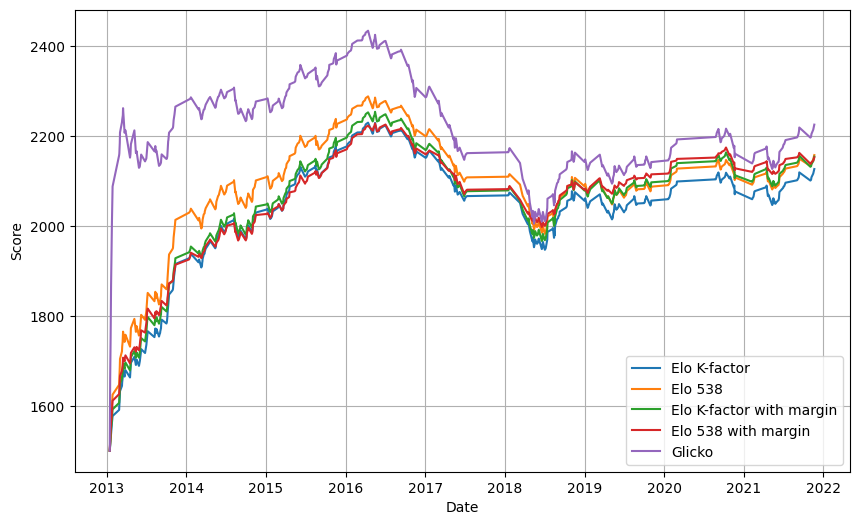

In [62]:
def get_individual_data(df, player_name):
    player_mask = (df["winner_name"] == player_name) | (df["loser_name"] == player_name)
    df_player = df[player_mask].copy()
    player_won = df_player["winner_name"] == player_name

    df_player["before_game"] = np.where(player_won, df_player["winner_before_game"], df_player["loser_before_game"])
    df_player = df_player.sort_values("tourney_date")
    return df_player

def plot_elo_scores(player_name, df_player_k_factor, df_player_538, df_player_k_factor_with_margin, df_player_538_with_margin, df_player_glicko):
    plt.figure(figsize=(10, 6))
    plt.plot(df_player_k_factor["tourney_date"], df_player_k_factor["before_game"], label="Elo K-factor")
    plt.plot(df_player_538["tourney_date"], df_player_538["before_game"], label="Elo 538")
    plt.plot(df_player_k_factor_with_margin["tourney_date"], df_player_k_factor_with_margin["before_game"], label="Elo K-factor with margin")
    plt.plot(df_player_538_with_margin["tourney_date"], df_player_538_with_margin["before_game"], label="Elo 538 with margin")
    plt.plot(df_player_glicko["tourney_date"], df_player_glicko["before_game"], label="Glicko")
    plt.xlabel("Date")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

player_name = "Djokovic N."

df_elo_train, _ = implement_elo(df_train, k_fixed_optimise)
df_elo_train_538, _ = implement_elo(df_train, k_538_optimise)
df_elo_train_with_margin, _ = implement_elo_with_margin(df_train, k_margin_func_optimise)
df_elo_train_538_with_margin, _ = implement_elo_with_margin(df_train, k_538_with_margin_optimise)
df_glicko_train, _ , _ = implement_glicko(df_train, 100.00, 0.01) 

df_player_k_factor = get_individual_data(df_elo_train, player_name)
df_player_538 = get_individual_data(df_elo_train_538, player_name)
df_player_k_factor_with_margin = get_individual_data(df_elo_train_with_margin, player_name)
df_player_538_with_margin = get_individual_data(df_elo_train_538_with_margin, player_name)
df_player_glicko = get_individual_data(df_glicko_train, player_name)

plot_elo_scores(player_name, df_player_k_factor, df_player_538, df_player_k_factor_with_margin, df_player_538_with_margin, df_player_glicko)

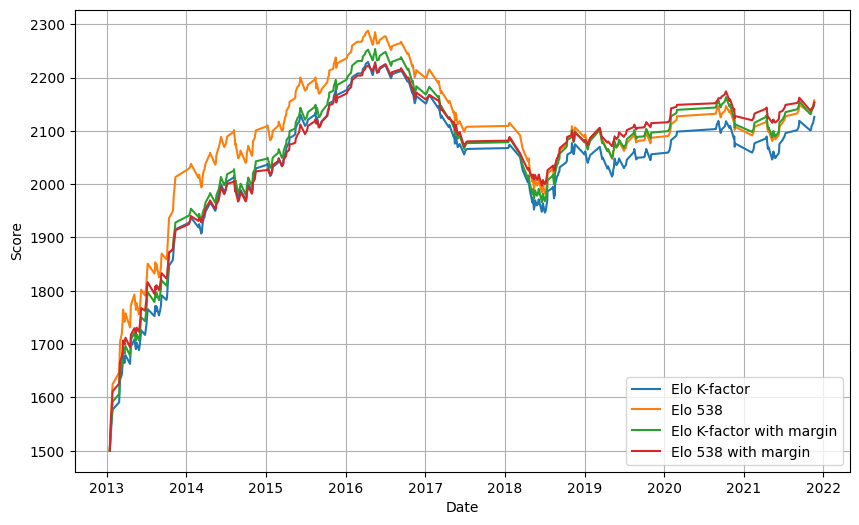

In [63]:
def get_individual_data(df, player_name):
    player_mask = (df["winner_name"] == player_name) | (df["loser_name"] == player_name)
    df_player = df[player_mask].copy()
    player_won = df_player["winner_name"] == player_name

    df_player["before_game"] = np.where(player_won, df_player["winner_before_game"], df_player["loser_before_game"])
    df_player = df_player.sort_values("tourney_date")
    return df_player

def plot_elo_scores(player_name, df_player_k_factor, df_player_538, df_player_k_factor_with_margin, df_player_538_with_margin):
    plt.figure(figsize=(10, 6))
    plt.plot(df_player_k_factor["tourney_date"], df_player_k_factor["before_game"], label="Elo K-factor")
    plt.plot(df_player_538["tourney_date"], df_player_538["before_game"], label="Elo 538")
    plt.plot(df_player_k_factor_with_margin["tourney_date"], df_player_k_factor_with_margin["before_game"], label="Elo K-factor with margin")
    plt.plot(df_player_538_with_margin["tourney_date"], df_player_538_with_margin["before_game"], label="Elo 538 with margin")
    plt.xlabel("Date")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

player_name = "Djokovic N."

df_elo_train, _ = implement_elo(df_train, k_fixed_optimise)
df_elo_train_538, _ = implement_elo(df_train, k_538_optimise)
df_elo_train_with_margin, _ = implement_elo_with_margin(df_train, k_margin_func_optimise)
df_elo_train_538_with_margin, _ = implement_elo_with_margin(df_train, k_538_with_margin_optimise)

df_player_k_factor = get_individual_data(df_elo_train, player_name)
df_player_538 = get_individual_data(df_elo_train_538, player_name)
df_player_k_factor_with_margin = get_individual_data(df_elo_train_with_margin, player_name)
df_player_538_with_margin = get_individual_data(df_elo_train_538_with_margin, player_name)

plot_elo_scores(player_name, df_player_k_factor, df_player_538, df_player_k_factor_with_margin, df_player_538_with_margin)

## Log Loss Plot

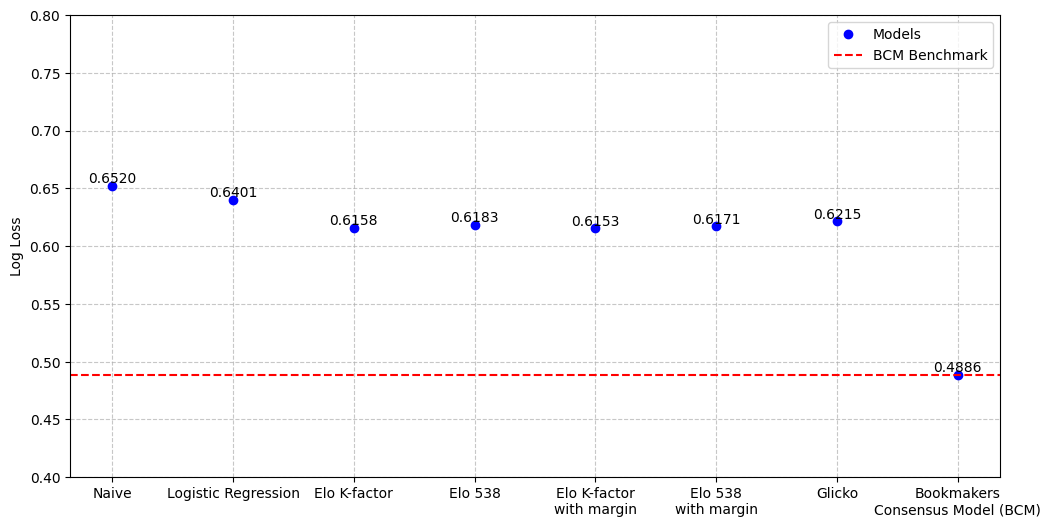

In [64]:
log_loss_values = {
    "Naive": naive_stats["log_loss"],
    "Logistic Regression": logistic_stats["log_loss"],
    "Elo K-factor": elo_k_stats["log_loss"],
    "Elo 538": elo_538_stats["log_loss"],
    "Elo K-factor\nwith margin": elo_k_margin_stats["log_loss"],
    "Elo 538\nwith margin": elo_538_margin_stats["log_loss"],
    "Glicko": glicko_stats["log_loss"],
    "Bookmakers\nConsensus Model (BCM)": bcm_stats["log_loss"]
}

models = list(log_loss_values.keys())
log_losses = list(log_loss_values.values())

plt.figure(figsize=(12, 6))
plt.plot(models, log_losses, marker='o', linestyle=' ', color='b', label="Models")

for i, (model, log_loss) in enumerate(log_loss_values.items()):
    plt.text(i, log_loss, f'{log_loss:.4f}', ha='center', va='bottom', fontsize=10)

plt.axhline(y=log_loss_values["Bookmakers\nConsensus Model (BCM)"], color='r', linestyle='--', label="BCM Benchmark")
plt.ylabel('Log Loss')
plt.xticks(rotation=0, fontsize=10)  
plt.ylim(0.4, 0.8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## Accuracy Plot

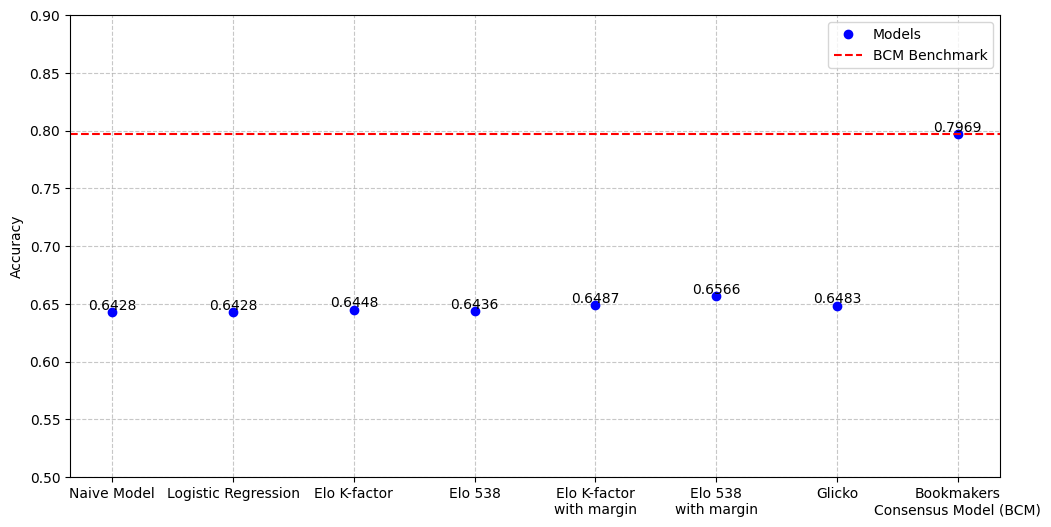

In [65]:
accuracy_values = {
    "Naive Model": naive_stats["accuracy"],
    "Logistic Regression": logistic_stats["accuracy"],
    "Elo K-factor": elo_k_stats["accuracy"],
    "Elo 538": elo_538_stats["accuracy"],
    "Elo K-factor\nwith margin": elo_k_margin_stats["accuracy"],
    "Elo 538\nwith margin": elo_538_margin_stats["accuracy"],
    "Glicko": glicko_stats["accuracy"],
    "Bookmakers\nConsensus Model (BCM)": bcm_stats["accuracy"]
}

models = list(accuracy_values.keys())
accuracies = list(accuracy_values.values())

plt.figure(figsize=(12, 6))
plt.plot(models, accuracies, marker='o', linestyle=' ', color='b', label="Models")
for i, (model, accuracy) in enumerate(accuracy_values.items()):
    plt.text(i, accuracy, f'{accuracy:.4f}', ha='center', va='bottom')
plt.axhline(y=accuracy_values["Bookmakers\nConsensus Model (BCM)"], color='r', linestyle='--', label="BCM Benchmark")
plt.ylabel('Accuracy')
plt.xticks(rotation=0, fontsize=10)  
plt.ylim(0.5, 0.9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()